In [ ]:
#import image from drives
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/deep learning"

 Correct_Way			        Incorrect_Way
'deep learning kia '		       'proposal deep learning project.gdoc'
'draft notes codigo decription .gdoc'   Untitled0.ipynb
'Final Report Deep Learning.gdoc'


# **Import the data**

In [ ]:
import os
import cv2

#path folder in drive
correct_path = "/content/drive/MyDrive/deep learning/Correct_Way"
incorrect_path = "/content/drive/MyDrive/deep learning/Incorrect_Way"

#check folder image
def load_images(path):
    imgs = []


    if not os.path.isdir(path):
        print(f"folder not found: {path}")
        return imgs

    print(f"I read from: {path}")
    print("folder contents:", os.listdir(path))

    for file in os.listdir(path):
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            full_path = os.path.join(path, file)
            img = cv2.imread(full_path)
            if img is None:
                print(f"image not loaded correctly: {full_path}")
            else:
                imgs.append(img)

    print(f"Found {len(imgs)} image in {path}")
    return imgs

#upload image
correct_imgs = load_images(correct_path)
incorrect_imgs = load_images(incorrect_path)

print("Correct:", len(correct_imgs))
print("Incorrect:", len(incorrect_imgs))

I read from: /content/drive/MyDrive/deep learning/Correct_Way
folder contents: ['image5025.jpg', 'image4974.jpg', 'image4964.jpg', 'image5044.jpg', 'image5024.jpg', 'image5033.jpg', 'image5027.jpg', 'image4989.jpg', 'image5016.jpg', 'image4952.jpg', 'image4970.jpg', 'image5026.jpg', 'image4955.jpg', 'image4956.jpg', 'image5023.jpg', 'image5028.jpg', 'image4983.jpg', 'image5051.jpg', 'image4982.jpg', 'image5034.jpg', 'image5036.jpg', 'image5019.jpg', 'image5047.jpg', 'image4979.jpg', 'image4953.jpg', 'image5022.jpg', 'image5011.jpg', 'image4963.jpg', 'image4966.jpg', 'image4967.jpg', 'image5008.jpg', 'image4973.jpg', 'image4960.jpg', 'image4991.jpg', 'image4988.jpg', 'image4992.jpg', 'image5012.jpg', 'image5038.jpg', 'image5029.jpg', 'image4972.jpg', 'image5000.jpg', 'image4927.jpg', 'image4938.jpg', 'image4886.jpg', 'image4869.jpg', 'image4887.jpg', 'image4836.jpg', 'image4891.jpg', 'image4890.jpg', 'image4834.jpg', 'image4831.jpg', 'image4929.jpg', 'image4946.jpg', 'image4862.jpg', 'i

# **Seeds for reproducibility**

In [ ]:
import random
import numpy as np
import torch



SEED = 9999
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

print("Random sample (Python):", random.random())
print("Random sample (NumPy):", np.random.rand())
print("Random sample (PyTorch):", torch.rand(1).item())

Random sample (Python): 0.8347577610922152
Random sample (NumPy): 0.8233890742543671
Random sample (PyTorch): 0.7876027822494507


## **Data**

In [ ]:


# 1) Shuffle each class once (reproducible)
random.shuffle(correct_imgs)
random.shuffle(incorrect_imgs)

# 2) Count images (classes already equal)
n_total = len(correct_imgs)

# 3) Compute split sizes
n_train = int(0.7  * n_total)     # 70%
n_val   = int(0.15 * n_total)     # 15%
n_test  = n_total - n_train - n_val  # ≈ 15%

# 4) Split correct class
correct_train = correct_imgs[:n_train]
correct_val   = correct_imgs[n_train:n_train + n_val]
correct_test  = correct_imgs[n_train + n_val:]

# 5) Split incorrect class
incorrect_train = incorrect_imgs[:n_train]
incorrect_val   = incorrect_imgs[n_train:n_train + n_val]
incorrect_test  = incorrect_imgs[n_train + n_val:]

# 6) Merge images + labels
X_train = correct_train + incorrect_train
y_train = [0] * len(correct_train) + [1] * len(incorrect_train)

X_val = correct_val + incorrect_val
y_val = [0] * len(correct_val) + [1] * len(incorrect_val)

X_test = correct_test + incorrect_test
y_test = [0] * len(correct_test) + [1] * len(incorrect_test)

# 7) Shuffle the combined sets ONCE (keep pairing!)
train_data = list(zip(X_train, y_train))
val_data   = list(zip(X_val, y_val))
test_data  = list(zip(X_test, y_test))

random.shuffle(train_data)
random.shuffle(val_data)
random.shuffle(test_data)

# 8) Unzip back
X_train, y_train = zip(*train_data)
X_val,   y_val   = zip(*val_data)
X_test,  y_test  = zip(*test_data)

# 9) Summary
print("Train ->", len(X_train), "images,", sum(y_train), "incorrect,", len(X_train)-sum(y_train), "correct")
print("Val   ->", len(X_val),   "images,", sum(y_val),   "incorrect,", len(X_val)-sum(y_val),   "correct")
print("Test  ->", len(X_test),  "images,", sum(y_test),  "incorrect,", len(X_test)-sum(y_test),  "correct")


Train -> 5102 images, 2551 incorrect, 2551 correct
Val   -> 1092 images, 546 incorrect, 546 correct
Test  -> 1096 images, 548 incorrect, 548 correct


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import cv2

# Basic transform for own CNN: resize + tensor (no augmentation)
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),      # change if your CNN uses another input size
    T.ToTensor(),              # scales to [0,1]
    # If you want simple normalization, uncomment:
    # T.Normalize(mean=[0.5, 0.5, 0.5],
    #             std=[0.5, 0.5, 0.5]),
])

class HelmetDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        # ensure indexable sequences
        self.images = list(images)
        self.labels = list(labels)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        # OpenCV -> RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            img = self.transform(img)

        label = torch.tensor(label, dtype=torch.long)

        return img, label


# build datasets from your split arrays
trainset = HelmetDataset(X_train, y_train, transform=transform)
valset   = HelmetDataset(X_val,   y_val,   transform=transform)
testset  = HelmetDataset(X_test,  y_test,  transform=transform)

BATCH_SIZE   = 8


train_iterator = DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_iterator = DataLoader(
    valset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_iterator = DataLoader(
    testset,
    batch_size=BATCH_SIZE,
    shuffle=False
)


## **Visualizing the data**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def show_batch(images, labels, class_names={0: "Correct", 1: "Incorrect"}):
    """
    images: tensor (B, C, H, W)
    labels: tensor or list of ints (B)
    """
    images = images.cpu()
    labels = labels.cpu()

    n = len(images)
    rows = int(np.sqrt(n))
    cols = int(np.ceil(n / rows))

    plt.figure(figsize=(cols * 3, rows * 3))

    for i in range(n):
        img = images[i].permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        label = int(labels[i].item())

        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img)
        ax.set_title(class_names[label])
        ax.axis("off")

    plt.tight_layout()
    plt.show()


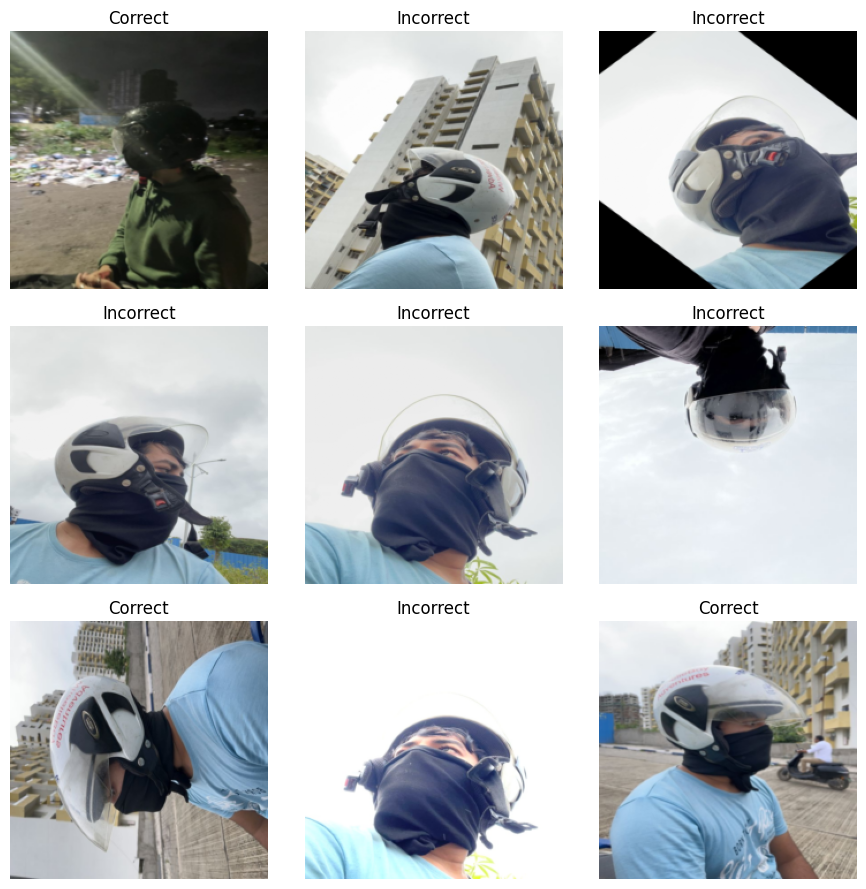

In [ ]:
example_imgs = []
example_lbls = []

for i in range(9):
    img, lbl = trainset[i]     # this applies transform → tensor
    example_imgs.append(img)
    example_lbls.append(lbl)

example_imgs = torch.stack(example_imgs)
example_lbls = torch.tensor(example_lbls)

show_batch(example_imgs, example_lbls)


## **Convolutional Neural Network (CNN_baseline)**

In [ ]:
# define the CNN architecture
import torch
import torch.nn as nn
import torch.nn.functional as F

class Helmet_CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # -------- Block 1 --------
        # Input: 3 x 128 x 128  → 16 x 64 x 64
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(16)

        # -------- Block 2 --------
        # Input: 16 x 64 x 64 → 32 x 32 x 32
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(32)

        # -------- Block 3 --------
        # Input: 32 x 32 x 32 → 64 x 16 x 16
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(64)

        # MaxPool: halves height and width
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Global Average Pooling: 64 x 16 x 16 → 64 x 1 x 1
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Classifier head
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 2)    # 2 classes: incorrect (0), correct (1)

    def forward(self, x):
        # Block 1
        x = self.pool(F.relu(self.bn1(self.conv1(x))))   # → 16x64x64

        # Block 2
        x = self.pool(F.relu(self.bn2(self.conv2(x))))   # → 32x32x32

        # Block 3
        x = self.pool(F.relu(self.bn3(self.conv3(x))))   # → 64x16x16

        # GAP
        x = self.gap(x)             # → 64x1x1
        x = x.view(x.size(0), -1)   # → 64

        # Classifier
        x = self.dropout(x)
        x = F.relu(self.fc1(x))

        x = self.dropout(x)
        x = self.fc2(x)             # logits

        return x

#move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Helmet_CNN().to(device)



In [ ]:
from torchsummary import summary

summary(model,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
       BatchNorm2d-2         [-1, 16, 128, 128]              32
         MaxPool2d-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           4,640
       BatchNorm2d-5           [-1, 32, 64, 64]              64
         MaxPool2d-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          18,496
       BatchNorm2d-8           [-1, 64, 32, 32]             128
         MaxPool2d-9           [-1, 64, 16, 16]               0
AdaptiveAvgPool2d-10             [-1, 64, 1, 1]               0
          Dropout-11                   [-1, 64]               0
           Linear-12                   [-1, 32]           2,080
          Dropout-13                   [-1, 32]               0
           Linear-14                   

# **Training**

In [ ]:
from tqdm.notebook import tqdm
import torch

def calculate_accuracy(y_pred, y):
    preds = y_pred.argmax(dim=1)
    correct = (preds == y).sum().item()
    total = y.size(0)
    return correct, total


def train(model, iterator, optimizer, criterion, device):

    model.train()

    epoch_loss = 0.0
    correct_total = 0
    n_total = 0

    for x, y in tqdm(iterator, desc="Training", leave=False):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)
        loss = criterion(y_pred, y)

        loss.backward()
        optimizer.step()

        correct, total = calculate_accuracy(y_pred, y)

        epoch_loss += loss.item() * total
        correct_total += correct
        n_total += total

    avg_loss = epoch_loss / n_total
    avg_acc  = correct_total / n_total

    return avg_loss, avg_acc


def evaluate(model, iterator, criterion, device):

    model.eval()

    epoch_loss = 0.0
    correct_total = 0
    n_total = 0

    with torch.no_grad():
        for x, y in tqdm(iterator, desc="Evaluating", leave=False):
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = criterion(y_pred, y)

            correct, total = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item() * total
            correct_total += correct
            n_total += total

    avg_loss = epoch_loss / n_total
    avg_acc  = correct_total / n_total

    return avg_loss, avg_acc


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [ ]:
import time
import torch.optim as optim
import torch.nn as nn
from tqdm.notebook import tqdm

def train_model(model, train_iterator, val_iterator, device,
                epochs=30, lr=1e-3, model_path='best-model.pt'):

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_valid_loss = float('inf')

    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    for epoch in tqdm(range(epochs), desc="Epochs"):

        start_time = time.monotonic()

        train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
        valid_loss, valid_acc = evaluate(model, val_iterator, criterion, device)

        # save best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), model_path)

        end_time = time.monotonic()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)

    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'valid_losses': valid_losses,
        'valid_accuracies': valid_accuracies,
        'best_model_path': model_path
    }



In [ ]:
stats = train_model(
    model=model,
    train_iterator=train_iterator,
    val_iterator=val_iterator,
    device=device,
    epochs=30,
    lr=1e-3,
    model_path='best-cnn.pt',

)


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 41s
	Train Loss: 0.598 | Train Acc: 68.05%
	 Val. Loss: 0.614 |  Val. Acc: 65.93%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 40s
	Train Loss: 0.548 | Train Acc: 71.50%
	 Val. Loss: 0.569 |  Val. Acc: 74.82%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 39s
	Train Loss: 0.529 | Train Acc: 73.58%
	 Val. Loss: 0.528 |  Val. Acc: 71.43%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 40s
	Train Loss: 0.523 | Train Acc: 73.52%
	 Val. Loss: 0.462 |  Val. Acc: 75.37%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 40s
	Train Loss: 0.507 | Train Acc: 74.23%
	 Val. Loss: 0.429 |  Val. Acc: 77.38%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 40s
	Train Loss: 0.494 | Train Acc: 74.91%
	 Val. Loss: 0.837 |  Val. Acc: 63.83%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 40s
	Train Loss: 0.481 | Train Acc: 75.54%
	 Val. Loss: 0.516 |  Val. Acc: 69.96%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 39s
	Train Loss: 0.477 | Train Acc: 76.32%
	 Val. Loss: 0.421 |  Val. Acc: 75.82%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 39s
	Train Loss: 0.470 | Train Acc: 75.97%
	 Val. Loss: 0.398 |  Val. Acc: 78.30%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 39s
	Train Loss: 0.472 | Train Acc: 76.38%
	 Val. Loss: 0.472 |  Val. Acc: 72.80%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 39s
	Train Loss: 0.466 | Train Acc: 76.36%
	 Val. Loss: 0.411 |  Val. Acc: 76.28%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 39s
	Train Loss: 0.463 | Train Acc: 76.81%
	 Val. Loss: 0.419 |  Val. Acc: 78.30%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 39s
	Train Loss: 0.462 | Train Acc: 76.58%
	 Val. Loss: 0.405 |  Val. Acc: 80.13%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 40s
	Train Loss: 0.461 | Train Acc: 76.95%
	 Val. Loss: 0.399 |  Val. Acc: 78.02%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 39s
	Train Loss: 0.456 | Train Acc: 76.99%
	 Val. Loss: 0.388 |  Val. Acc: 79.03%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 39s
	Train Loss: 0.457 | Train Acc: 77.07%
	 Val. Loss: 0.408 |  Val. Acc: 77.56%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 39s
	Train Loss: 0.442 | Train Acc: 77.60%
	 Val. Loss: 0.449 |  Val. Acc: 75.18%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 40s
	Train Loss: 0.441 | Train Acc: 77.21%
	 Val. Loss: 0.519 |  Val. Acc: 76.65%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 40s
	Train Loss: 0.436 | Train Acc: 78.19%
	 Val. Loss: 0.578 |  Val. Acc: 69.96%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 39s
	Train Loss: 0.427 | Train Acc: 78.85%
	 Val. Loss: 0.442 |  Val. Acc: 74.54%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 21 | Epoch Time: 0m 39s
	Train Loss: 0.423 | Train Acc: 79.24%
	 Val. Loss: 0.448 |  Val. Acc: 73.81%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 0m 40s
	Train Loss: 0.421 | Train Acc: 79.11%
	 Val. Loss: 0.373 |  Val. Acc: 80.49%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 23 | Epoch Time: 0m 40s
	Train Loss: 0.429 | Train Acc: 79.48%
	 Val. Loss: 0.375 |  Val. Acc: 81.04%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: 0m 40s
	Train Loss: 0.406 | Train Acc: 79.77%
	 Val. Loss: 0.585 |  Val. Acc: 70.42%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 25 | Epoch Time: 0m 40s
	Train Loss: 0.414 | Train Acc: 79.75%
	 Val. Loss: 0.354 |  Val. Acc: 80.13%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 26 | Epoch Time: 0m 40s
	Train Loss: 0.410 | Train Acc: 80.16%
	 Val. Loss: 0.339 |  Val. Acc: 82.69%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 27 | Epoch Time: 0m 40s
	Train Loss: 0.396 | Train Acc: 81.20%
	 Val. Loss: 0.337 |  Val. Acc: 84.80%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 28 | Epoch Time: 0m 39s
	Train Loss: 0.404 | Train Acc: 80.64%
	 Val. Loss: 0.333 |  Val. Acc: 84.25%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 29 | Epoch Time: 0m 39s
	Train Loss: 0.397 | Train Acc: 80.67%
	 Val. Loss: 0.373 |  Val. Acc: 78.85%


Training:   0%|          | 0/638 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 30 | Epoch Time: 0m 40s
	Train Loss: 0.388 | Train Acc: 81.30%
	 Val. Loss: 0.322 |  Val. Acc: 86.26%


# **Evaluation**

In [ ]:
# Load best saved model
model.load_state_dict(torch.load('best-cnn.pt', map_location=device))
model = model.to(device)
criterion = nn.CrossEntropyLoss()
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_acc*100:.2f}%")

Evaluating:   0%|          | 0/137 [00:00<?, ?it/s]

Final Test Loss: 0.3432
Final Test Accuracy: 84.12%


# **Confusion matrix**

In [ ]:
import numpy as np
import torch

def get_all_predictions(model, iterator, device):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in iterator:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            preds = y_pred.argmax(dim=1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    return all_preds, all_labels

# get predictions and true labels
y_pred, y_true = get_all_predictions(model, test_iterator, device)


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)


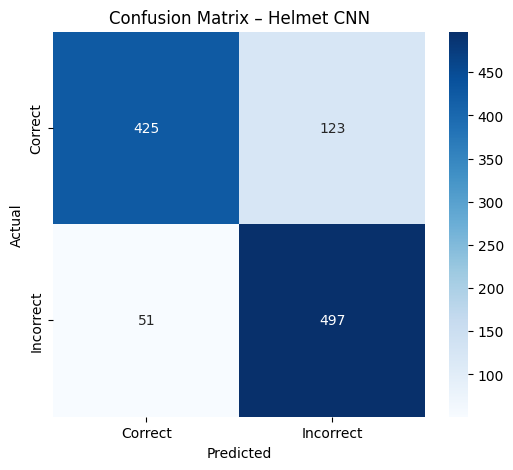

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Correct', 'Incorrect'],
            yticklabels=['Correct', 'Incorrect'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – Helmet CNN')
plt.show()




In [ ]:
TN, FP, FN, TP = cm.ravel()

# totals
total = TN + FP + FN + TP

# Accuracy
accuracy = (TP + TN) / total

# Precision / PPV
precision = TP / (TP + FP + 1e-8)

# Recall / Sensitivity / True Positive Rate
recall = TP / (TP + FN + 1e-8)

# Specificity / True Negative Rate
specificity = TN / (TN + FP + 1e-8)

# F1 Score
f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

# False Positive Rate
fpr = FP / (FP + TN + 1e-8)

# False Negative Rate
fnr = FN / (FN + TP + 1e-8)

# Balanced Accuracy
balanced_accuracy = (recall + specificity) / 2

# Print values
print("---- Confusion Matrix Metrics ----")
print(f"Accuracy:            {accuracy*100:.2f}%")
print(f"Precision (PPV):     {precision*100:.2f}%")
print(f"Recall (Sensitivity):{recall*100:.2f}%")
print(f"Specificity (TNR):   {specificity*100:.2f}%")
print(f"F1 Score:            {f1*100:.2f}%")
print(f"False Pos. Rate:     {fpr*100:.2f}%")
print(f"False Neg. Rate:     {fnr*100:.2f}%")
print(f"Balanced Accuracy:   {balanced_accuracy*100:.2f}%")

---- Confusion Matrix Metrics ----
Accuracy:            84.12%
Precision (PPV):     80.16%
Recall (Sensitivity):90.69%
Specificity (TNR):   77.55%
F1 Score:            85.10%
False Pos. Rate:     22.45%
False Neg. Rate:     9.31%
Balanced Accuracy:   84.12%
